In [83]:
import http.client
import networkx as nx
import freeman as fm
from json import loads, dump
from scipy import stats
from unidecode import unidecode
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# https://api.rawg.io/docs/#operation/games_list

# game_nodes = {
#     id: {name: name, list: [l]},
#     id: {name: name, list: [l]},
#     id: {name: name, list: [l]}
# }

# game_edges = {
#     id: { 
#           l : peso,
#           l : peso,
#         },
#     id: { 
#           l : peso,
#           l : peso,
#         },
#     id: { 
#           l : peso,
#           l : peso,
#         },
# }

def get_rawg_api_endpoint(endpoint, conn, h) -> str:
    conn.request("GET", endpoint, headers=h)
    return loads(conn.getresponse().read())

def rawg_api_connection() -> None:
    conn = http.client.HTTPSConnection("rawg-video-games-database.p.rapidapi.com")
    headers = {
        'x-rapidapi-host': "rawg-video-games-database.p.rapidapi.com",
        'x-rapidapi-key': "c665cc5f66mshee40894946e0d28p1c5de7jsn49fab80d50ae"
    }

    return conn, headers

def gen_data(conn, h, review_threshold = 250, month = [1, 12], day = [1, 31], year = 2015) -> None:
    rawg_data = {"results":[]}
    game_found_debug = 0

    for j in range(month[0], month[1] + 1):
        for i in range(day[0], day[1] + 1):
            page = 1
            response_count = 0
            response = {"count": None}

            while (response_count != response["count"]):
                query = "/games?page_size=40&page={}&dates={}-{:02d}-{:02d},{}-{:02d}-{:02d}".format(page, year, j, i, year, j, i)
                response = get_rawg_api_endpoint(endpoint=query, conn=conn, h=h)
                response_count += len(response["results"])
                print()
                print(query)

                for game in response['results']:
                    if game["ratings_count"] > review_threshold and game["slug"] not in rawg_data.keys():
                        rawg_data["results"] += [game]
                        game_found_debug += 1

                page += 1

    with open('aa.json', 'w') as file:
            dump(rawg_data, file)

    print(game_found_debug)

def gen_game_nodes(game_nodes, data, network_type) -> None:
    for game in data["results"]:
        l = []

        if network_type == 1:
            for game_tag in game["tags"]: l += [game_tag["slug"]]

        if network_type == 2:
            for game_platform in game["platforms"]: l += [game_platform["platform"]["slug"]]
        
        # deixar vazio se platform == null?
        game_nodes[game["id"]] = { "name" : game["slug"], "list" : l }

def gen_game_edges(game_nodes, game_edges) -> None:
    for game1 in game_nodes:
        targets = {}
        
        for game2 in game_nodes:
            if game1 != game2:
                for e in game_nodes[game1]["list"]:
                    if e in game_nodes[game2]["list"] and game2 in game_edges and game1 not in game_edges[game2]:
                        if game2 in targets:
                            targets[game2] += 1
                        else: 
                            targets[game2] = 0 
        
        game_edges[game1] = targets

def build_gml(game_nodes, game_edges, network, weight_list) -> None:

    with open(network, 'w') as file:
        file.write('graph [\n')
        file.write('  directed 0\n')

        for n in game_nodes.keys():
            file.write('  node [\n')
            file.write('    id {}\n'.format(n))
            file.write('    name "{}"\n'.format(unidecode(game_nodes[n]["name"])))
            file.write('  ]\n')

        for n in game_edges.keys():
            for m in game_edges[n].keys():
                file.write('  edge [\n')
                file.write('    source {}\n'.format(n))
                file.write('    target {}\n'.format(m))
                file.write('    weight {}\n'.format(game_edges[n][m]))
                file.write('  ]\n')
                weight_list += [game_edges[n][m]]

        file.write(']\n')

def network_nx(network):  

    g = fm.load(network)
    g.label_nodes('name')
    g.set_all_nodes(size=10, labpos='hover')
    g.draw()
    return g

def betweeness_network(network):
    bc = nx.betweenness_centrality(network)
    network.scale_nodes_size(bc)
    network.draw()

def degree_network(network):
    dc = nx.degree_centrality(network)
    network.scale_nodes_size(dc)
    network.draw()

def gen_x_y(data, x1, x2, y):
    for game in data["results"]:
        lx1 = []
        lx2 = []

        for game_tag in game["tags"]: lx1 += [game_tag["slug"]]

        for game_platform in game["platforms"]: lx2 += [game_platform["platform"]["slug"]]

        x1 += [lx1]
        x2 += [lx2]
        y += [game["rating"]]

def unique(lst):
    l = []

    for lis in lst:
        for category in lis:
            if category not in l:
                l += [category]
    
    return l

def one_hot_encoding(element, lists):
    one_hot_list = []
    for lis in lists:
        if element in lis: one_hot_list += [1]
        else: one_hot_list += [0]

    return one_hot_list

def gen_df(x_tag, x_platforms, y_rv):
    x_tag_unique = unique(x_tag)
    d = {"ratings" : y_rv}
    
    for category in x_tag_unique:
        d[category] = one_hot_encoding(category, x_tag)
        
    return pd.DataFrame(data=d)

def gen_nw_1(rawg_data, weight_nw_1):
    # Rede 1: Nos: jogos; Arestas: jogos que compartilham a mesma categoria.
    print("REDE 1")
    print("Nós: jogos;")
    print("Arestas: jogos que compartilham a mesma categoria;")
     
    game_nodes = {}
    game_edges = {}

    gen_game_nodes(game_nodes, rawg_data, 1)
    gen_game_edges(game_nodes, game_edges)
    build_gml(game_nodes, game_edges, 'rede1.gml', weight_nw_1)
    
    g = network_nx('rede1.gml')

    # C. calcular as métricas (chamar as funções vistas em aula ou outras);
    betweeness_network(g)
    degree_network(g)

    return g

def gen_nw_2(rawg_data, weight_nw_2):
    # Rede 2: Nos: jogos; Arestas: jogos que compartilham a mesma plataforma de jogo.
    print("REDE 2")
    print("Nós: jogos;")
    print("Arestas: jogos que compartilham a mesma plataforma de jogo;")
     
    game_nodes = {}
    game_edges = {}

    gen_game_nodes(game_nodes, rawg_data, 2)
    gen_game_edges(game_nodes, game_edges)
    build_gml(game_nodes, game_edges, 'rede2.gml', weight_nw_2)
    
    g = network_nx('rede2.gml')

    # C. calcular as métricas (chamar as funções vistas em aula ou outras);
    betweeness_network(g)
    degree_network(g)

    return g

REDE 1
Nós: jogos;
Arestas: jogos que compartilham a mesma categoria;



action-adventure

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.060
Model:                            OLS   Adj. R-squared (uncentered):              0.049
Method:                 Least Squares   F-statistic:                              5.354
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                      0.0231
Time:                        17:53:57   Log-Likelihood:                         -231.38
No. Observations:                  85   AIC:                                      464.8
Df Residuals:                      84   BIC:                                      467.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


atmosfera

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.518
Model:                            OLS   Adj. R-squared (uncentered):              0.512
Method:                 Least Squares   F-statistic:                              90.25
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                    5.85e-15
Time:                        17:53:57   Log-Likelihood:                         -203.00
No. Observations:                  85   AIC:                                      408.0
Df Residuals:                      84   BIC:                                      410.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
               

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


shuter-ot-tretego-litsa

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.086
Model:                            OLS   Adj. R-squared (uncentered):              0.075
Method:                 Least Squares   F-statistic:                              7.883
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                     0.00620
Time:                        17:53:58   Log-Likelihood:                         -230.20
No. Observations:                  85   AIC:                                      462.4
Df Residuals:                      84   BIC:                                      464.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
 

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


building

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.087
Model:                            OLS   Adj. R-squared (uncentered):              0.076
Method:                 Least Squares   F-statistic:                              8.003
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                     0.00584
Time:                        17:53:58   Log-Likelihood:                         -230.14
No. Observations:                  85   AIC:                                      462.3
Df Residuals:                      84   BIC:                                      464.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


strange

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.168
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.283
Time:                        17:53:58   Log-Likelihood:                         -233.42
No. Observations:                  85   AIC:                                      468.8
Df Residuals:                      84   BIC:                                      471.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


free-to-play

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.070
Model:                            OLS   Adj. R-squared (uncentered):              0.059
Method:                 Least Squares   F-statistic:                              6.360
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                      0.0136
Time:                        17:53:58   Log-Likelihood:                         -230.91
No. Observations:                  85   AIC:                                      463.8
Df Residuals:                      84   BIC:                                      466.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
            

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


economy

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.026
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              2.212
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.141
Time:                        17:53:58   Log-Likelihood:                         -232.91
No. Observations:                  85   AIC:                                      467.8
Df Residuals:                      84   BIC:                                      470.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


simuliator-svidanii

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.029
Method:                 Least Squares   F-statistic:                              3.581
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                      0.0619
Time:                        17:53:59   Log-Likelihood:                         -232.24
No. Observations:                  85   AIC:                                      466.5
Df Residuals:                      84   BIC:                                      468.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
     

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


crowdfunded

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              1.078
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.302
Time:                        17:53:59   Log-Likelihood:                         -233.47
No. Observations:                  85   AIC:                                      468.9
Df Residuals:                      84   BIC:                                      471.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
             

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


muzyka

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.157
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.285
Time:                        17:53:59   Log-Likelihood:                         -233.43
No. Observations:                  85   AIC:                                      468.9
Df Residuals:                      84   BIC:                                      471.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 c

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


batman

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              1.239
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.269
Time:                        17:53:59   Log-Likelihood:                         -233.39
No. Observations:                  85   AIC:                                      468.8
Df Residuals:                      84   BIC:                                      471.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 c

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.026
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              2.282
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.135
Time:                        17:53:59   Log-Likelihood:                         -232.87
No. Observations:                  85   AIC:                                      467.7
Df Residuals:                      84   BIC:                                      470.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


siurrealistichnaia

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              1.318
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.254
Time:                        17:54:00   Log-Likelihood:                         -233.35
No. Observations:                  85   AIC:                                      468.7
Df Residuals:                      84   BIC:                                      471.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
      

[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.


solo

                                 OLS Regression Results                                
Dep. Variable:                ratings   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.151
Date:                Wed, 04 Nov 2020   Prob (F-statistic):                       0.286
Time:                        17:54:00   Log-Likelihood:                         -233.43
No. Observations:                  85   AIC:                                      468.9
Df Residuals:                      84   BIC:                                      471.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coe

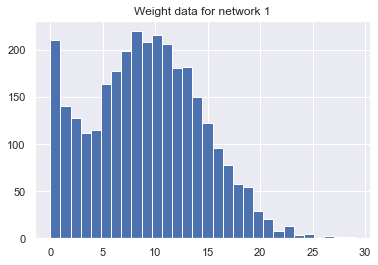

In [90]:
# A. obter os dados (chamadas de API, parsing de CSV, etc.);

#rawg_connection, rawg_headers = rawg_api_connection()
#gen_data(rawg_connection, rawg_headers, month=[1, 2])

with open('aa.json', 'r') as file: rawg_data = loads(file.read())

# B. construir a rede (escrever GML, carregar na NetworkX);
weight_nw_1 = []
g = gen_nw_1(rawg_data, weight_nw_1)
plt.hist(weight_nw_1, bins=30, alpha=1)
plt.title('Weight data for network 1')
# weight_nw_2 = []
# g = gen_nw_2(rawg_data, weight_nw_2)

# D. fazer os testes de hipótese (regressão, teste-t, etc.).
x_tag = []
x_platforms = []
y_rv = []
gen_x_y(rawg_data, x_tag, x_platforms, y_rv)
df = gen_df(x_tag, x_platforms, y_rv)

for category in df:
    if category != 'ratings':
        print()
        print(category)
        print()
        model = sm.OLS(df['ratings'], df[category])
        result = model.fit()
        print(result.summary())
        print()

In [85]:
df

ratings  action-adventure  alternate-history  atmospheric  cinematic  \
0      3.75                 1                  1            1          1   
1      4.30                 0                  0            1          0   
2      3.08                 0                  0            1          0   
3      4.00                 0                  0            1          0   
4      4.18                 0                  0            1          0   
..      ...               ...                ...          ...        ...   
80     3.26                 0                  0            0          0   
81     3.58                 0                  0            0          0   
82     3.32                 0                  0            1          0   
83     3.74                 0                  0            1          0   
84     3.54                 0                  0            0          0   

    exploration  mature  nudity  singleplayer  stealth  ...  text-based  \
0             1       1       1             1        1  ...           0   
1             0       0       0             1        0  ...           0   
2             0       1       0             1        0  ...           0   
3             0       0       0             1        0  ...           0   
4             0       0       0             1        1  ...           0   
..          ...     ...     ...           ...      ...  ...         ...   
80            0       0       0             1        0  ...           0   
81            0       0       0             1        0  ...           1   
82            1       0       0             1        0  ...           0   
83            0       0       0             1        0  ...           0   
84            0       0       0             1        0  ...           0   

    roman-2  tekstovaia  3d-vision  offroad  bezdorozhe  mechs  \
0         0           0          0        0           0      0   
1         0           0          0        0           0      0   
2         0           0          0        0           0      0   
3         0           0          0        0           0      0   
4         0           0          0        0           0      0   
..      ...         ...        ...      ...         ...    ...   
80        0           0          0        0           0      0   
81        1           1          0        0           0      0   
82        0           0          0        0           0      0   
83        0           0          1        1           1      0   
84        0           0          0        0           0      1   

    twin-stick-shooter  mekhi  tvin-stik-shuter  
0                    0      0                 0  
1                    0      0                 0  
2                    0      0                 0  
3                    0      0                 0  
4                    0      0                 0  
..                 ...    ...               ...  
80                   0      0                 0  
81                   0      0                 0  
82                   0      0                 0  
83                   0      0                 0  
84                   1      1                 1  

[85 rows x 489 columns]